# Few-Shot Learning with Presto

### Demo Overview 

The purpose of the Demo is to show-case how to: 

- effectively train models on limited amount of annotated data
- show how multi-sensor and multi-temporal information can be integrated by mean of DL models

To this end, we will:

1) give a short introduction about Foundation Models and Presto
2) provide the definition of Few-Shot learning
3) apply Presto to perfrom Few-Shot learning on a regression and a classification task


### 1) Foundation Models

A Foundation Model is a pretrained model that is trained on large and diverse unlabelled datasets to learn general patterns and features. Due to its strong generalization capabilities, it can be adapted for a wide range of applications that use similar types of input data.

**Presto** (**P**retrained **Re**mote **S**ensing **T**ransf**o**rmer) is a foundation model trained on a large, unlabeled dataset of multi-sensor remote sensing data (Sentinel-2, Sentinel-1, Meteorological and Topography) pixel-timeseries. It is able to capture long-range relationships across time and sensor dimensions, improving the signal-to-noise ratio and providing a concise, informative representation of the inputs. 
We made use of the Presto version developed in collaboration with [WorldCereal](https://github.com/WorldCereal/presto-worldcereal/)

Originally trained on Montlhy composites, Presto has been refined to be able to ingest decadal data and to be fine-tuned for regression and classification tasks   

![General overview of the proposed pipeline for implementing few-shot learning using a Foundation Model pre-trained on multi-sensor data time-series.](/images/ScaleAG_FM_applications.svg)

In [2]:
%load_ext autoreload
%autoreload 2
import catboost as cb
import os
import openeo
from loguru import logger
import geopandas as gpd
from pathlib import Path
import numpy as np
from torch.utils.data import DataLoader
from scaleagdata_vito.presto.presto_utils import evaluate
from scaleagdata_vito.presto.datasets import ScaleAG10DDataset
from scaleagdata_vito.presto.presto_df import (add_labels, xr_to_df, filter_ts)
from scaleagdata_vito.presto.presto_utils import load_pretrained_model_from_url, get_encodings
from scaleagdata_vito.openeo.preprocessing import run_openeo_extraction_job, merge_datacubes
from openeo_gfmap import (
    Backend,
    BackendContext,
    TemporalContext,
    FetchType,
)
from openeo_gfmap.manager.job_splitters import split_job_hex


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Presto pretrained models

In [3]:
# Decadal and Monthly Presto models trained in self-supervised mode on WorldCereal data
presto_ss_10d_wc = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/scaleagdata/models/presto-ss-wc_10D.pt"
presto_ss_30d_wc = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/scaleagdata/models/presto-ss-wc_30D.pt"
model_wc_10d = load_pretrained_model_from_url(
    presto_ss_10d_wc, finetuned=False, ss_dekadal=True, strict=False, device="cpu"
)
model_wc_30d = load_pretrained_model_from_url(
    presto_ss_30d_wc, finetuned=False, ss_dekadal=False, strict=False, device="cpu"
)

2024-09-10 13:10:16.427 | INFO     | scaleagdata_vito.presto.presto_utils:load_pretrained_model_from_url:56 -  Initialize Presto dekadal architecture with 10d ss trained WorldCereal Presto weights...
2024-09-10 13:10:16.716 | INFO     | scaleagdata_vito.presto.presto_utils:load_pretrained_model_from_url:68 -  Initialize Presto dekadal architecture with 30d ss trained WorldCereal Presto weights...


### Fetch data from OpenEO
TODO: add description on how to setup job parameters

In [4]:
# load dataframe with labels and polygons we want to extract openeo data for
gdf = (
    gpd.read_file(
        "/projects/TAP/HEScaleAgData/timeseries_modelling/datasets/apr2024_AVR_subfields/data/AVR_fields_10000_100000_subfields_yield_bel_nl_roads_removed.geojson"
    ).iloc[:100]
    .drop(columns=["date"])
)

# setup OpenEO job parameters
job_params = dict(
    connection=openeo.connect("https://openeo.creo.vito.be/openeo/").authenticate_oidc(),
    backend_context=BackendContext(Backend.CDSE),
    temporal_extent=TemporalContext(
        start_date="2022-01-01",
        end_date="2022-12-31",
    ),
    fetch_type=FetchType.POINT,
    disable_meteo=False,
    out_format="NetCDF",
    title="ScaleAGData_demo",
    split_dataset=False,
    output_path="/home/vito/millig/gio/data/scaleag_demo/test"
)

output_path = Path(job_params["output_path"])
if not os.path.exists(job_params["output_path"]):
    output_path.mkdir(parents=True, exist_ok=True)

Authenticated using refresh token.


In [ ]:
if job_params["split_dataset"]:
    datasets = split_job_hex(gdf)
    for i, sub_gdf in enumerate(datasets):
        logger.info(f"Extracting OpenEO data for subset {i}")
        output_path_frame = output_path / f"cube_{i}"
        output_path_frame.mkdir(parents=True, exist_ok=True)
        run_openeo_extraction_job(sub_gdf, str(output_path_frame), job_params)
else:
    logger.info(f"Extracting OpenEO data for dataset")
    run_openeo_extraction_job(gdf, str(output_path), job_params)

In [7]:
subset_files = list(output_path.glob("*/*.nc"))
dataset = subset_files[0]
for d in subset_files[1:]:
    dataset = merge_datacubes(dataset, d)
dataset.to_netcdf(output_path / "demo_dataset_yield.nc")

### Test Presto on yield task 

In [6]:
dataset_file = "/home/vito/millig/gio/data/scaleag_demo/test/demo_dataset_yield.nc"
gdf_label_file = (
    "/projects/TAP/HEScaleAgData/" \
    "timeseries_modelling/datasets/apr2024_AVR_subfields/" \
    "data/AVR_fields_10000_100000_subfields_yield_bel_nl_roads_removed.geojson"
)
dataset = add_labels(xr_to_df(dataset_file), gdf_label_file)

In [7]:
# split avoiding data leakage
np.random.seed(3)
df_p = dataset['parentname'].unique()
train_frac = 0.90
sample_idx = np.random.choice(range(0, len(df_p)), size=int(train_frac*len(df_p)), replace=False)
train_df = dataset[dataset['parentname'].isin(df_p[sample_idx])].reset_index(drop=True)
val_df = dataset[~dataset['parentname'].isin(df_p[sample_idx])].reset_index(drop=True)

print(f"Validation: number of field IDs: {len(val_df['parentname'].unique())}, number of samples: {len(val_df)}")
print(f"Training: number of field IDs: {len(train_df['parentname'].unique())}, number of samples: {len(train_df)}")

Validation: number of field IDs: 113, number of samples: 1476
Training: number of field IDs: 1010, number of samples: 12389


In [8]:
dl_train = DataLoader(
    ScaleAG10DDataset(
        train_df, target_name="median_yield", task="regression"
    ),
    batch_size=256,
    shuffle=True,
    num_workers=2,
)

dl_val = DataLoader(
    ScaleAG10DDataset(
        val_df, target_name="median_yield", task="regression"
    ),
    batch_size=256,
    shuffle=False,
    num_workers=2,
)

In [9]:
model_name = "presto-ss-wc_10D"
encodings_np, targets = get_encodings(dl_train, model_wc_10d)

logger.info(f"Fitting Catboost model with {model_name} encodings")

cbm = cb.CatBoostRegressor(
    random_state=3,
    task_type="GPU",
    devices="0:1",
    logging_level="Silent",
    loss_function="RMSE",
)
train_dataset = cb.Pool(encodings_np, targets)
cbm.fit(train_dataset)

2024-09-10 13:15:19.733 | INFO     | __main__:<module>:4 - Fitting Catboost model with presto-ss-wc_10D encodings
TBB Warning: The number of workers is currently limited to 1. The request for 95 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



In [16]:
metrics, preds, targets = evaluate(
    model_wc_10d,
    cbm,
    dl_val,
    task="regression",
    up_val=120000,
    low_val=10000,
    )
metrics

{'RMSE': 17136.652414557015,
 'R2_score': 0.3772495466014979,
 'explained_var_score': 0.3902602111794452}

### Test Presto on Crop/no-Crop task

In [77]:
import pandas as pd

# Load WorldCereal datasets from artifactory
wc_train_dataset = pd.read_parquet(
    "/home/vito/millig/gio/data/presto_ft/rawts-10d_train.parquet"
)

wc_val_dataset = pd.read_parquet(
    "/home/vito/millig/gio/data/presto_ft/rawts-10d_val.parquet"
)

def filter_remove_noncrops(df: pd.DataFrame) -> pd.DataFrame:
    crop_labels = [10, 11, 12, 13]
    df = df.loc[df.LANDCOVER_LABEL.isin(crop_labels)]
    return df

wc_train_dataset = filter_remove_noncrops(wc_train_dataset).sample(frac=0.05)
wc_val_dataset = filter_remove_noncrops(wc_val_dataset).sample(frac=0.05)

# convert the target variable to binary
wc_train_dataset["LANDCOVER_LABEL"] = (
    wc_train_dataset["LANDCOVER_LABEL"] == 11
).astype(int)

wc_val_dataset["LANDCOVER_LABEL"] = (
    wc_val_dataset["LANDCOVER_LABEL"] == 11
    ).astype(int)

print(f"Number of Training samples: {len(wc_train_dataset)}")
print(f"Number of Validation samples: {len(wc_val_dataset)}")

Number of Training samples: 22782
Number of Validation samples: 5693


(0.0, 28475.0)

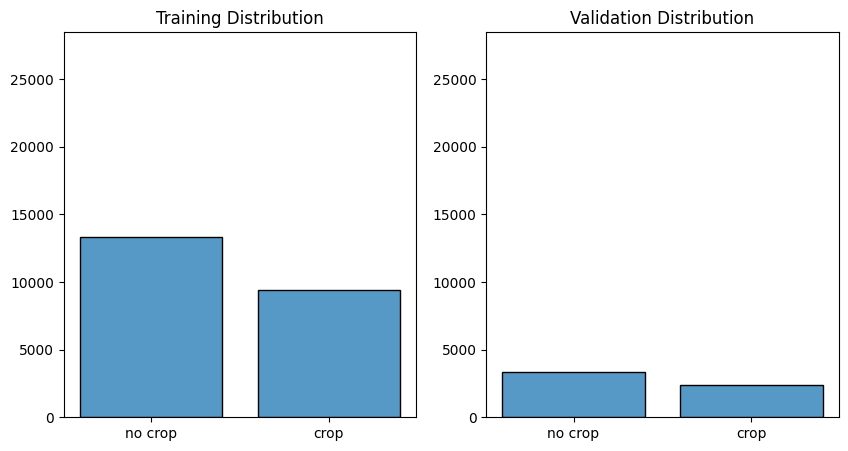

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(wc_train_dataset["LANDCOVER_LABEL"], ax=ax[0], discrete=True, shrink=0.8)
ax[0].set_title("Training Distribution")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["no crop", "crop"])
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_ylim(0, len(wc_train_dataset) + len(wc_val_dataset))

sns.histplot(wc_val_dataset["LANDCOVER_LABEL"], ax=ax[1], discrete=True, shrink=0.8)
ax[1].set_title("Validation Distribution")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["no crop", "crop"])
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_ylim(0, len(wc_train_dataset) + len(wc_val_dataset))

In [79]:
wc_dl_train = DataLoader(
    ScaleAG10DDataset(
        wc_val_dataset, target_name="LANDCOVER_LABEL", task="binary",
    ),
    batch_size=256,
    shuffle=True,
    num_workers=2,
)
wc_dl_val = DataLoader(
    ScaleAG10DDataset(
        wc_train_dataset, target_name="LANDCOVER_LABEL", task="binary",
    ),
    batch_size=256,
    shuffle=False,
    num_workers=2,
)

In [80]:
model_name = "presto-ss-wc_10D"
encodings_train, target_train = get_encodings(wc_dl_train, model_wc_10d)

In [81]:
logger.info(f"Fitting Catboost model with {model_name} encodings")

wc_cbm = cb.CatBoostClassifier(
    random_state=3,
    task_type="GPU",
    devices="0:1",
    logging_level="Silent",
)
train_dataset = cb.Pool(encodings_train, target_train)
wc_cbm.fit(train_dataset)

2024-09-10 14:21:02.274 | INFO     | __main__:<module>:1 - Fitting Catboost model with presto-ss-wc_10D encodings


In [82]:
metrics, preds, targets = evaluate(
    model_wc_10d,
    wc_cbm,
    wc_dl_val,
    task="binary",
)
print(metrics)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85     13342
           1       0.80      0.75      0.78      9440

    accuracy                           0.82     22782
   macro avg       0.82      0.81      0.81     22782
weighted avg       0.82      0.82      0.82     22782

